# BigMart Sales Prediction Analysis - Regression

In [343]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

Reading The Dataset

In [344]:
df = pd.read_csv('Train.csv')
print(df.shape)
df.head()

(8523, 12)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Checking the no of features and info.

In [345]:
list(df.columns)

['Item_Identifier',
 'Item_Weight',
 'Item_Fat_Content',
 'Item_Visibility',
 'Item_Type',
 'Item_MRP',
 'Outlet_Identifier',
 'Outlet_Establishment_Year',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Item_Outlet_Sales']

In [346]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


Checking the categorical Columns:

In [347]:
cat_col = []
for x in df.dtypes.index:
    if df.dtypes[x] == 'object':
        cat_col.append(x)
print("catagorical columns:",cat_col,end =" ")

catagorical columns: ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'] 

In [348]:
df.apply(lambda x: len(x.unique()))

Item_Identifier              1559
Item_Weight                   416
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     4
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

Checking Null Values and Normalizing Them:

In [349]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [350]:
df['Item_Weight'] = df['Item_Weight'].fillna(df['Item_Weight'].mean())

In [351]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy="most_frequent")
df['Outlet_Size'] = imp.fit_transform(df['Outlet_Size'].values.reshape(-1,1))

In [352]:
df.isnull().any()

Item_Identifier              False
Item_Weight                  False
Item_Fat_Content             False
Item_Visibility              False
Item_Type                    False
Item_MRP                     False
Outlet_Identifier            False
Outlet_Establishment_Year    False
Outlet_Size                  False
Outlet_Location_Type         False
Outlet_Type                  False
Item_Outlet_Sales            False
dtype: bool

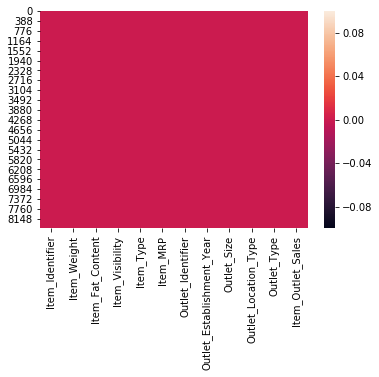

In [353]:
sns.heatmap(df.isnull())

Feature Engineering And Transformation:

A close look at each of Item Identifier shows that they start with 'FD':Food,'NC':Non_Consumable,'DR':Drinks
            
for this we can only create 3 categories.            

In [354]:
df['Item_Identifier'].head()

0    FDA15
1    DRC01
2    FDN15
3    FDX07
4    NCD19
Name: Item_Identifier, dtype: object

In [355]:
#Changing only First 2 characters:
df['New_item_type'] = df['Item_Identifier'].apply(lambda x: x[0:2])

In [358]:
df['New_item_type'] = df['New_item_type'].replace({'FD':'Food','DR':'Drinks','NC':'Non-Consumable'})
df['New_item_type'].value_counts()

Food              6125
Non-Consumable    1599
Drinks             799
Name: New_item_type, dtype: int64

In [359]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
New_item_type                 object
dtype: object

In [360]:
# Items which are more visible are going to sell more:
item_visg_avg = df.pivot_table(values='Item_Visibility',index='Item_Identifier')

In [361]:
item_visg_avg.head()

,Item_Visibility
Item_Identifier,
DRA12,0.031956
DRA24,0.048062
DRA59,0.134718
DRB01,0.082126
DRB13,0.008002


In [362]:
function = lambda x: x['Item_Visibility']/item_visg_avg['Item_Visibility'][item_visg_avg.index == x['Item_Identifier']][0]
df['item_visg_avg'] = df.apply(function,axis=1).astype(float)

In [363]:
df.apply(lambda x: len(x.value_counts()))

Item_Identifier              1559
Item_Weight                   416
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
New_item_type                   3
item_visg_avg                7988
dtype: int64

In [364]:
df['Item_Visibility'].value_counts()

0.000000    526
0.076975      3
0.041283      2
0.085622      2
0.187841      2
0.134976      2
0.107224      2
0.085275      2
0.076856      2
0.059836      2
0.112203      2
0.044024      2
0.072253      2
0.061271      2
0.061164      2
0.145266      2
0.081097      2
0.071958      2
0.103442      2
0.074613      2
0.072655      2
0.071833      2
0.136286      2
0.041355      2
0.026950      2
0.013952      2
0.160624      2
0.080640      2
0.097611      2
0.096592      2
           ... 
0.100641      1
0.122735      1
0.099024      1
0.054600      1
0.118859      1
0.162572      1
0.076745      1
0.015461      1
0.057655      1
0.042113      1
0.029565      1
0.066447      1
0.035954      1
0.083222      1
0.021413      1
0.030921      1
0.081119      1
0.052811      1
0.118080      1
0.046654      1
0.021469      1
0.060134      1
0.096658      1
0.019064      1
0.164197      1
0.092576      1
0.067544      1
0.115168      1
0.146896      1
0.050902      1
Name: Item_Visibility, L

In [365]:
df.loc[:,'Item_Visibility'].replace([0],[df['Item_Visibility'].mean()],inplace=True) # Replacing Zeros Value.

In [366]:
sum(df['Item_Visibility'] == 0)

0

In [367]:
for col in df.columns:
    if df[col].dtypes == 'object':
         print(f'{col}: {df[col].unique()}')

Item_Identifier: ['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']
Item_Fat_Content: ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
Item_Type: ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
Outlet_Identifier: ['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
Outlet_Size: ['Medium' 'High' 'Small']
Outlet_Location_Type: ['Tier 1' 'Tier 3' 'Tier 2']
Outlet_Type: ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']
New_item_type: ['Food' 'Drinks' 'Non-Consumable']


In [368]:
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [369]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'})
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

Exploratory Data Analysis:

1.Univariate Analysis

2.Multivariate Analysis.

In [370]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,item_visg_avg
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.070213,140.992782,1997.831867,2181.288914,1.000000
std,4.226124,0.048742,62.275067,8.371760,1706.499616,0.348957
min,4.555000,0.003575,31.290000,1985.000000,33.290000,0.000000
25%,9.310000,0.033085,93.826500,1987.000000,834.247400,0.892715
50%,12.857645,0.062517,143.012800,1999.000000,1794.331000,0.998970
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400,1.055863
max,21.350000,0.328391,266.888400,2009.000000,13086.964800,2.729420


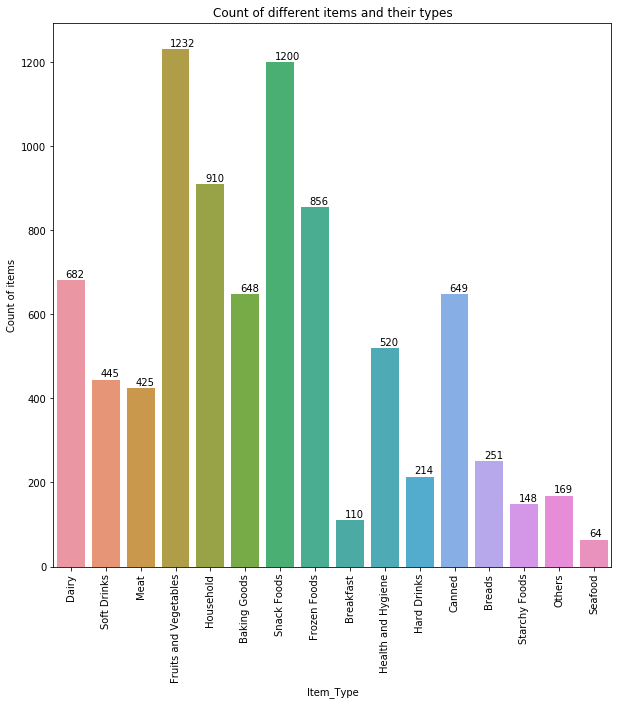

In [371]:
# Univariate Analysis checking the count of different Item Types:
plt.figure(figsize = (10, 10))
plt.title('Count of different items and their types')
ax=sns.countplot(x = 'Item_Type', data =df)
plt.xlabel('Item_Type')
plt.ylabel('Count of items')
plt.xticks(rotation = 90)
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+1), va='bottom',color= 'black')

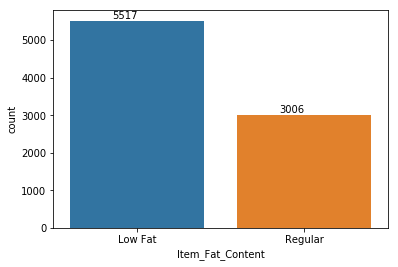

In [372]:
#Performing unvariate Analysis:
#Checking the item fat content:
ax = sns.countplot(df["Item_Fat_Content"])
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+1), va='bottom',
                    color= 'black')

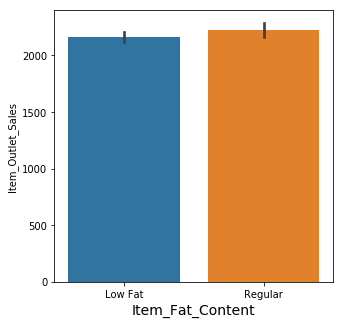

In [373]:
#Checking the item outlet sales for item fat content:
plt.figure(figsize=(5,5))
sns.barplot(data=df, y='Item_Outlet_Sales', x='Item_Fat_Content')
plt.xlabel('Item_Fat_Content', fontsize=14)
plt.show()

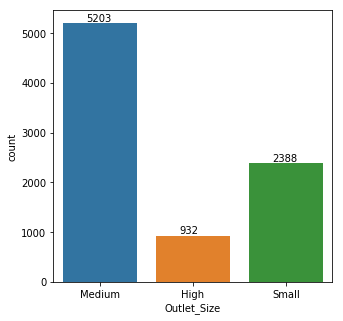

In [374]:
#Lets Check the Outlet Size.
plt.figure(figsize=(5,5))
ax = sns.countplot(df["Outlet_Size"])
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+1), va='bottom',
                    color= 'black')

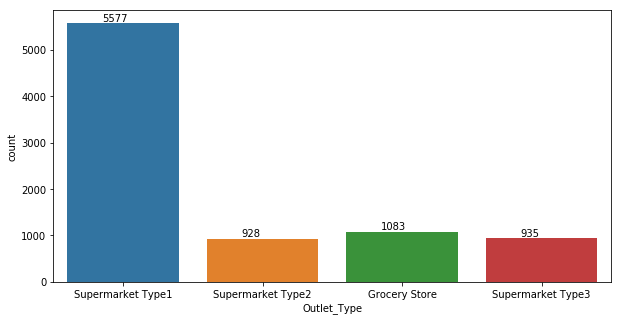

In [375]:
#Lets Check the Outlet type.
plt.figure(figsize=(10,5))
ax = sns.countplot(df["Outlet_Type"])
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+1), va='bottom',
                    color= 'black')

In [376]:
# Multivariate Analysis:
# Checking the item outlet sales on basic of item fat content and outlet location type.
sales=pd.pivot_table(index=['Item_Fat_Content', 'Outlet_Location_Type'],values='Item_Outlet_Sales',aggfunc='mean',data=df)
sales.head()

Item_Outlet_Sales
Item_Fat_Content Outlet_Location_Type                   
Low Fat          Tier 1                      1836.848815
                 Tier 2                      2285.675574
                 Tier 3                      2278.856201
Regular          Tier 1                      1949.660256
                 Tier 2                      2395.006755

In [377]:
#Item_Weight and Item_Outlet_Sales Analysis
ax = df.pivot_table(index=['Item_Weight','Item_Type'],values='Item_Outlet_Sales',aggfunc='mean')
ax.head()

,,Item_Outlet_Sales
Item_Weight,Item_Type,
4.555,Frozen Foods,1761.706800
4.590,Soft Drinks,1267.683200
4.610,Hard Drinks,1993.595429
4.615,Canned,4078.025000
4.635,Breads,2184.489800


Text(0.5, 1.0, ' Outlet size vs Item Sales Outlet')

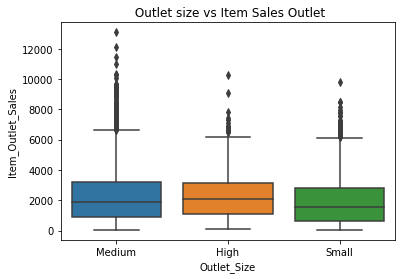

In [378]:
sns.boxplot(x='Outlet_Size',y='Item_Outlet_Sales',data= df)
plt.title(" Outlet size vs Item Sales Outlet")

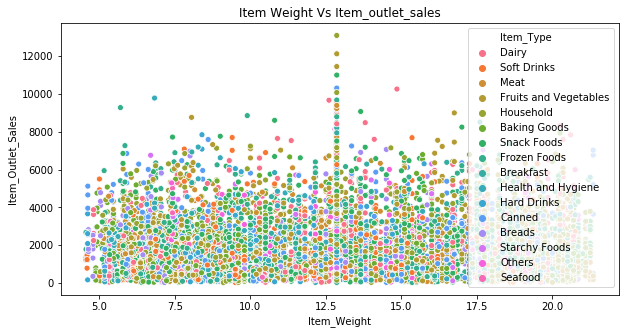

In [379]:
#Multivariate Analysis Item weight and item sales outlet Analysis:
plt.figure(figsize=(10,5))
plt.xlabel("Item_Weight")
plt.ylabel("Item_Outlet_Sales")
plt.title("Item Weight Vs Item_outlet_sales")
sns.scatterplot(x='Item_Weight',y='Item_Outlet_Sales',hue='Item_Type',data=df)

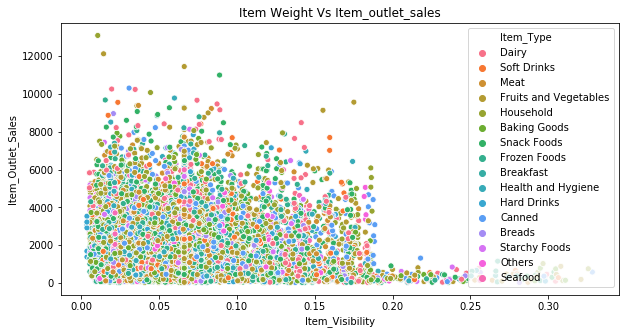

In [380]:
#Multivariate Analysis Item_Visibility and item sales outlet Analysis:
plt.figure(figsize=(10,5))
plt.xlabel("Item_Visibility")
plt.ylabel("Item_Outlet_Sales")
plt.title("Item Weight Vs Item_outlet_sales")
sns.scatterplot(x='Item_Visibility',y='Item_Outlet_Sales',hue='Item_Type',data=df)

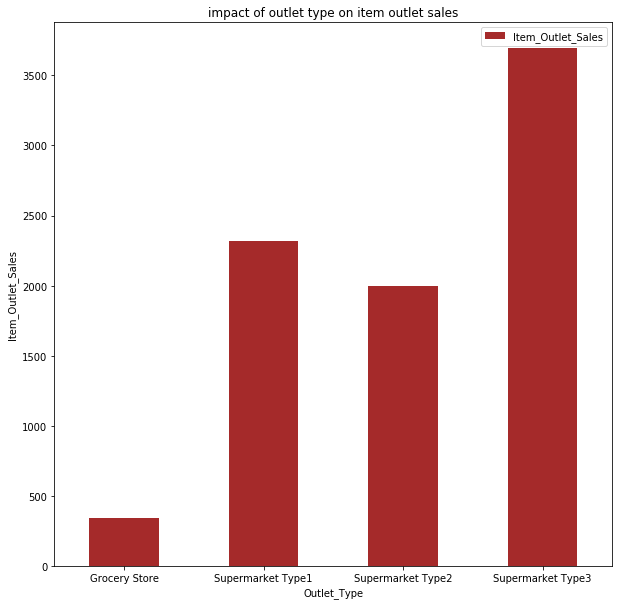

In [381]:
#impact of outlet type on item outlet sales:
outlet_type_pivot = \
df.pivot_table(index='Outlet_Type',values='Item_Outlet_Sales')
outlet_type_pivot.plot(kind='bar',color='brown',figsize=(10,10))
plt.xlabel('Outlet_Type')
plt.ylabel('Item_Outlet_Sales')
plt.title('impact of outlet type on item outlet sales')
plt.xticks(rotation=0)
plt.show()

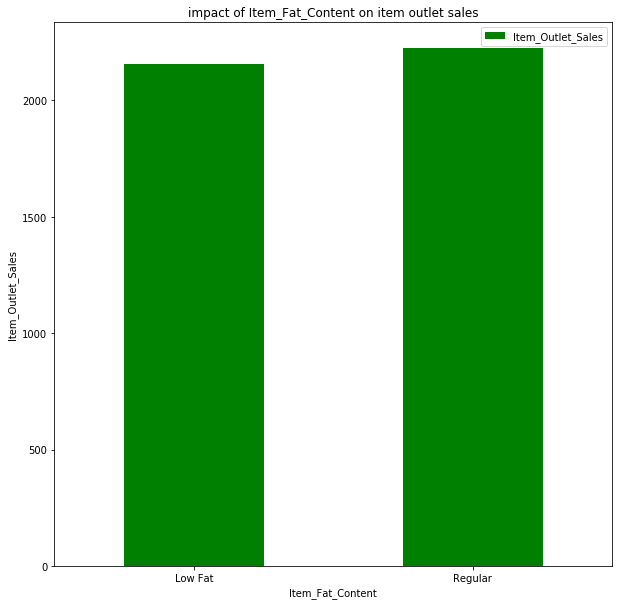

In [382]:
outlet_type_pivot = \
df.pivot_table(index='Item_Fat_Content',values='Item_Outlet_Sales')
outlet_type_pivot.plot(kind='bar',color='green',figsize=(10,10))
plt.xlabel('Item_Fat_Content')
plt.ylabel('Item_Outlet_Sales')
plt.title('impact of Item_Fat_Content on item outlet sales')
plt.xticks(rotation=0)
plt.show()

Checking the Skewness and Distribution:

In [383]:
df.skew()

Item_Weight                  0.090561
Item_Visibility              1.286877
Item_MRP                     0.127202
Outlet_Establishment_Year   -0.396641
Item_Outlet_Sales            1.177531
item_visg_avg               -0.600881
dtype: float64

0.09056145191764828
-0.8602944788067419


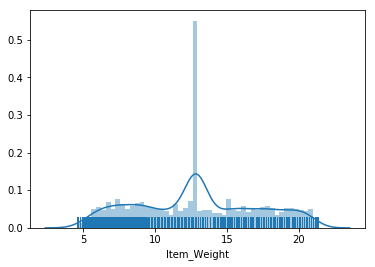

In [384]:
sns.distplot(df['Item_Weight'],rug=True,bins=50)
print(df['Item_Weight'].skew())
print(df['Item_Weight'].kurt())

1.2868767983596106
2.194146727370415


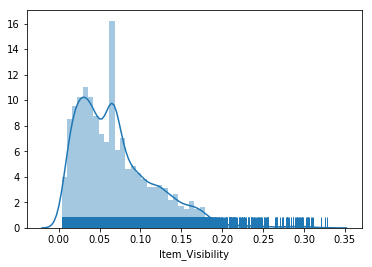

In [385]:
sns.distplot(df['Item_Visibility'],rug=True,bins=50)
print(df['Item_Visibility'].skew())
print(df['Item_Visibility'].kurt())

0.1272022683110526
-0.8897690936963571


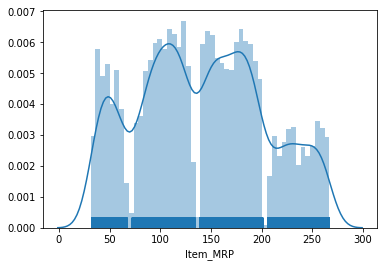

In [386]:
sns.distplot(df['Item_MRP'],rug=True,bins=50)
print(df['Item_MRP'].skew())
print(df['Item_MRP'].kurt())

1.1775306028542798
1.6158766814287264


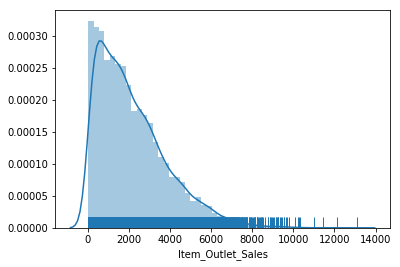

In [387]:
sns.distplot(df['Item_Outlet_Sales'],rug=True,bins=50)
print(df['Item_Outlet_Sales'].skew())
print(df['Item_Outlet_Sales'].kurt())

In [388]:
# Logarthim Transformation:
df['Item_Outlet_Sales'] = np.log(1+df['Item_Outlet_Sales'])

-0.8822656923242802
0.5329195223738816


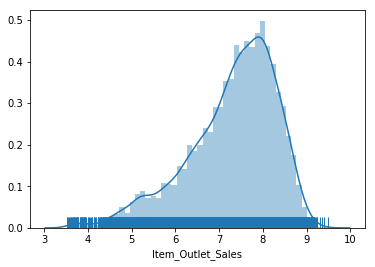

In [389]:
sns.distplot(df['Item_Outlet_Sales'],rug=True,bins=50)
print(df['Item_Outlet_Sales'].skew())
print(df['Item_Outlet_Sales'].kurt())

Checking The Corelation 

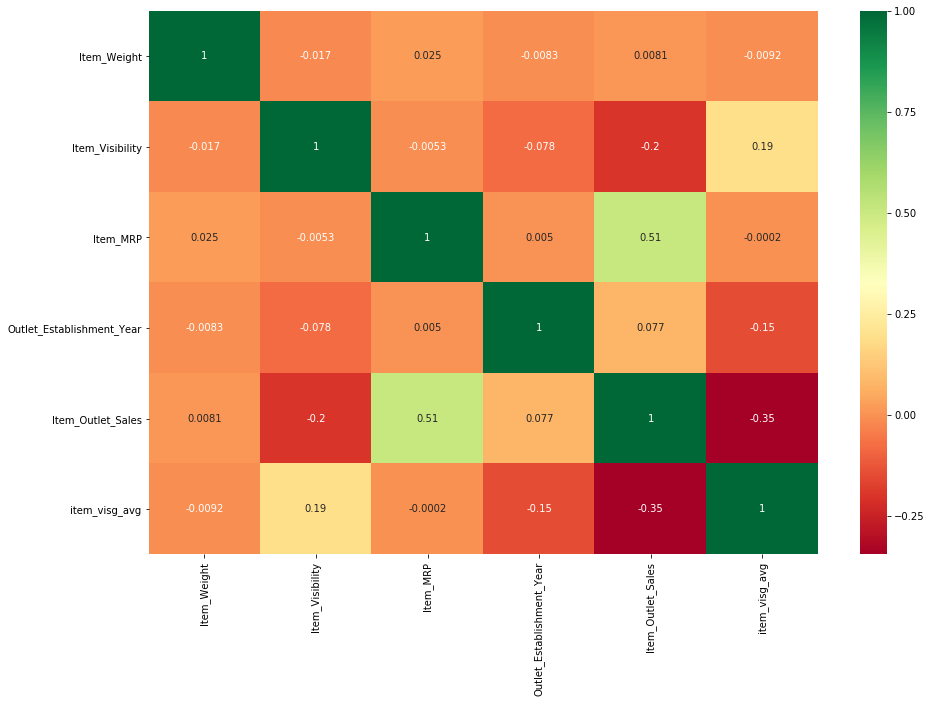

In [390]:
plt.figure(figsize=(15,10))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="RdYlGn")

Label Encoding and Data Preprocessing

In [391]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,New_item_type,item_visg_avg
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,8.225808,Food,0.922960
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,6.096776,Drinks,1.003057
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,7.648868,Food,0.831990
3,FDX07,19.20,Regular,0.066132,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,6.597664,Food,0.000000
4,NCD19,8.93,Low Fat,0.066132,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,6.903451,Non-Consumable,0.000000


In [392]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
columns = ['Item_Identifier','Item_Fat_Content','Item_Type','Outlet_Identifier','Outlet_Size','Outlet_Location_Type','Outlet_Type','New_item_type'] 
for col in columns:
    df[col] = le.fit_transform(df[col])

In [393]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,New_item_type,item_visg_avg
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,8.225808,1,0.922960
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,6.096776,0,1.003057
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,7.648868,1,0.831990
3,1121,19.20,1,0.066132,6,182.0950,0,1998,1,2,0,6.597664,1,0.000000
4,1297,8.93,0,0.066132,9,53.8614,1,1987,0,2,1,6.903451,2,0.000000


In [394]:
df.drop(columns=['Outlet_Establishment_Year','Item_Identifier','Outlet_Identifier'],axis=1,inplace=True)

In [395]:
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,New_item_type,item_visg_avg
0,9.30,0,0.016047,4,249.8092,1,0,1,8.225808,1,0.922960
1,5.92,1,0.019278,14,48.2692,1,2,2,6.096776,0,1.003057
2,17.50,0,0.016760,10,141.6180,1,0,1,7.648868,1,0.831990
3,19.20,1,0.066132,6,182.0950,1,2,0,6.597664,1,0.000000
4,8.93,0,0.066132,9,53.8614,0,2,1,6.903451,2,0.000000


Selecting Dependant and independant Variables:

In [430]:
X = df.drop('Item_Outlet_Sales',axis=1)
y = df['Item_Outlet_Sales']
print('shape of X is {}'.format(X.shape))
print('shape of y is {}'.format(y.shape))

shape of X is (8523, 10)
shape of y is (8523,)


In [398]:
# Important feature using ExtraTreesRegressor

from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)

ExtraTreesRegressor()

In [399]:
print(selection.feature_importances_)

[0.03252646 0.01115661 0.04427927 0.03187326 0.33128943 0.0162721
 0.01665338 0.38578613 0.01283734 0.11732601]


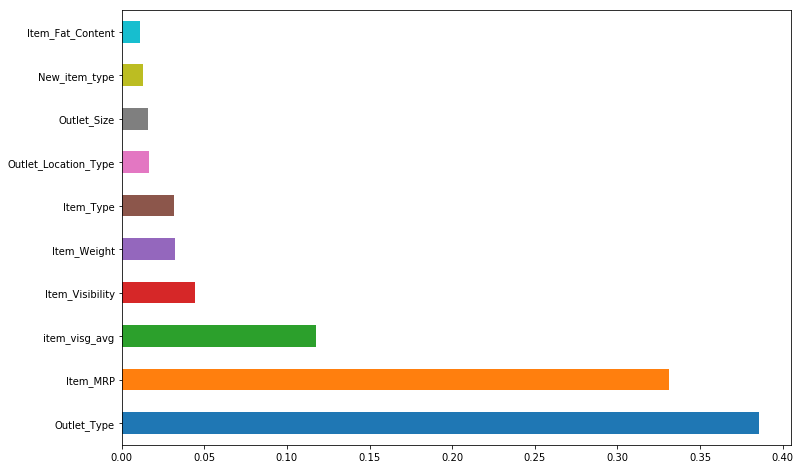

In [400]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

# Fitting model using Random Forest

Split dataset into train and test set in order to prediction w.r.t X_test

Import model

Fit the data

Predict w.r.t, X_test

In regression check RSME Score Plot graph

Training and Testing Split:

In [431]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("Item outlet sales  X_train dataset: ", X_train.shape)
print("Item outlet sales  y_train dataset: ", y_train.shape)
print("Item outlet sales  X_test dataset: ", X_test.shape)
print("Item outlet sales  y_test dataset: ", y_test.shape)

Item outlet sales  X_train dataset:  (6818, 10)
Item outlet sales  y_train dataset:  (6818,)
Item outlet sales  X_test dataset:  (1705, 10)
Item outlet sales  y_test dataset:  (1705,)


In [402]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score

In [403]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, y_train)

RandomForestRegressor()

In [409]:
y_pred = reg_rf.predict(X_test)

In [410]:
reg_rf.score(X_test, y_test)

0.7135289109125106

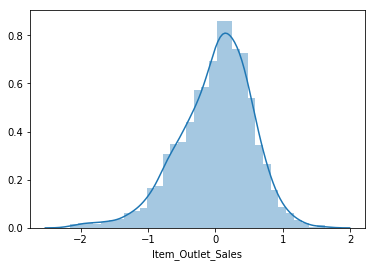

In [411]:
sns.distplot(y_test-y_pred)
plt.show()

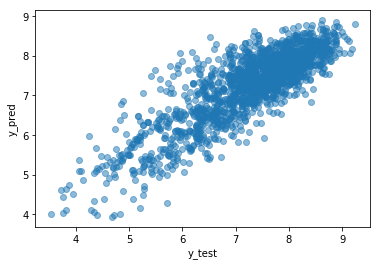

In [412]:
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [413]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.4269450777484737
MSE: 0.3011796875408966
RMSE: 0.5487984033694856


# Hyperparameter Tuning

In [414]:
from sklearn.model_selection import RandomizedSearchCV

In [415]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [416]:
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [417]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = reg_rf, param_distributions = random_grid,scoring='neg_mean_squared_error',
                               n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [418]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   9.4s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   9.2s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   8.5s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   8.2s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   8.3s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=  13.5s
[CV] n_estimators=1100, min_samples_split=10, mi

[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   4.0s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   3.9s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   4.0s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   3.9s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   4.1s
[CV] n_estimators=700, min_samples_split=15, min_sam

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  9.7min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [419]:
rf_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 100,
 'min_samples_leaf': 5,
 'max_features': 'auto',
 'max_depth': 15}

In [425]:
prediction = rf_random.predict(X_test)

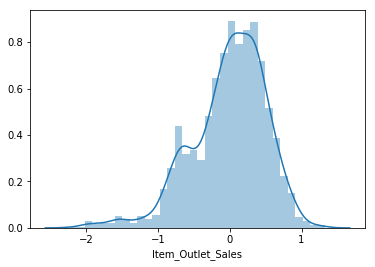

In [426]:
sns.distplot(y_test-prediction)
plt.show()

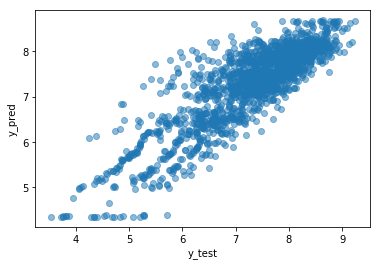

In [427]:
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [428]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 0.40211791405626535
MSE: 0.2701804394327498
RMSE: 0.5197888411968362


In [429]:
metrics.r2_score(y_test, prediction)

0.743014260468922